This simulates the Viscek model for flocking of birds.  Birds are defined by their (x,y) position, as well as the direction (vx,vy) of their velocity; the magnitudes of all birds' velocities are the same.

The birds move according to the following rules:
1. birds travel at a constant speed with a variable direction
2. pick a bird and align its velocity to its neighbours
3. add some noise to the direction
4. go through all birds
5. repeat for a set time


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

In [3]:
# Simulation parameters
v0           = 1.0      # velocity
eta          = 0.5      # random fluctuation in angle (in radians)
L            = 10       # size of box
R            = 2        # interaction radius
Rsq          = R**2     # square of the interaction radius
dt           = 0.2      # time step
Nt           = 80       # number of time steps
N            = 1000     # number of birds

#np.random.seed(17)      # set the random number generator seed

In [4]:
#new parameters
r = 0.2
vmax = 1.0
lambda_c = 1
lambda_a = 1
lambda_m = 1
num_drones = 3

In [5]:
def initialize_birds(N,L):
    '''
    Set initial positions, direction, and velocities 
    '''
    # bird positions
    x = np.random.rand(N,1)*L
    y = np.random.rand(N,1)*L

    # bird velocities
    theta = 2 * np.pi * np.random.rand(N,1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

In [6]:
def initialize_drones(num_drones, L):
    # drone positions
    x = np.random.rand(num_drones, 1) * L
    y = np.random.rand(num_drones, 1) * L

    # drone velocities
    vx = np.random.rand(num_drones, 1) * vmax
    vy = np.random.rand(num_drones, 1) * vmax

    return x, y, vx, vy

In [7]:
def apply_boundary_conditions(x,y,L):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

In [8]:
def update_positions(x,y,xv,vy,dt,L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += xv*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,L)
    return x, y

In [9]:
def update_drones(x_drones, y_drones, vx_drones, vy_drones, x_birds, y_birds, theta_birds):
    for i in range(len(x_drones)):
        # Calculate the average direction of nearby birds
        neighbors = np.linalg.norm(np.column_stack([x_birds - x_drones[i], y_birds - y_drones[i]]), axis=1) < R
        if np.any(neighbors):
            mean_direction = np.arctan2(np.mean(np.sin(theta_birds[neighbors])), np.mean(np.cos(theta_birds[neighbors])))
            # Update drone velocities away from areas with more birds
            vx_drones[i] += lambda_a * np.cos(mean_direction)
            vy_drones[i] += lambda_a * np.sin(mean_direction)

    x_drones, y_drones = apply_boundary_conditions(x_drones, y_drones, L)


    # Add code to update drone positions based on velocities
    x_drones += vx_drones * dt
    y_drones += vy_drones * dt

    return x_drones, y_drones, vx_drones, vy_drones

    

In [10]:
def update_birds(x_birds, y_birds, vx_birds, vy_birds, theta_birds, R, eta, N, dt, x_drones, y_drones):
    for i in range(len(x_birds)):
        if i < len(x_drones):  # Check if there are drones to consider
            # Calculate the direction away from nearby drones
            drones = np.linalg.norm(np.column_stack([x_birds - x_drones[i], y_birds - y_drones[i]]), axis=1) < R
            if np.any(drones):
                away_direction = np.arctan2(-np.mean(np.sin(theta_birds[drones])), -np.mean(np.cos(theta_birds[drones])))
                # Update bird velocities away from drones
                vx_birds[i] += lambda_a * np.cos(away_direction)
                vy_birds[i] += lambda_a * np.sin(away_direction)
    
    x_birds, y_birds = apply_boundary_conditions(x_birds, y_birds, L)


    # Add code to update bird positions based on velocities
    x_birds += vx_birds * dt
    y_birds += vy_birds * dt

    return x_birds, y_birds, vx_birds, vy_birds

In [11]:
def get_mean_theta(x, y, theta, Rsq, x_drones=None, y_drones=None, drone_flag=False):
    mean_theta = theta.copy()
    N = len(x)

    for bird in range(N):
        if drone_flag and x_drones is not None and y_drones is not None:
            # Calculate the direction away from nearby drones
            neighbors = np.linalg.norm(np.column_stack([x - x_drones, y - y_drones]), axis=1) < Rsq
        else:
            # Calculate the local average direction in a circle of radius R around each bird
            neighbors = np.linalg.norm(np.column_stack([x - x[bird], y - y[bird]]), axis=1) < Rsq

        sum_x = np.sum(np.cos(theta[neighbors]))
        sum_y = np.sum(np.sin(theta[neighbors]))
        mean_theta[bird] = np.arctan2(sum_y, sum_x)

    return mean_theta


In [12]:
def update_theta(x, y, theta, Rsq, eta, N, x_drones=None, y_drones=None, drone_flag=False):
    '''
    Update theta to be the mean value plus a random amount between -eta/2 and eta/2
    '''
    mean_theta = get_mean_theta(x, y, theta, Rsq, x_drones, y_drones, drone_flag)
    theta = mean_theta + eta * (np.random.rand(N, 1) - 0.5)
    return theta

In [13]:
def update_velocities(vx,vy,theta):
    '''
    Update the velocities given theta
    '''
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return vx, vy

In [14]:
def step(x_birds, y_birds, vx_birds, vy_birds, theta, R, eta, N, dt, x_drones, y_drones, vx_drones, vy_drones):
    # Compute a step in the dynamics:
    # - update the positions
    # - compute the new velocities
    x_birds, y_birds = update_positions(x_birds, y_birds, vx_birds, vy_birds, dt, L)
    x_drones, y_drones, vx_drones, vy_drones = update_drones(x_drones, y_drones, vx_drones, vy_drones, x_birds, y_birds, theta)
    x_birds, y_birds, vx_birds, vy_birds = update_birds(x_birds, y_birds, vx_birds, vy_birds, theta, R, eta, N, dt, x_drones, y_drones)
    
    # Update theta for birds and drones
    bird_theta = update_theta(x_birds, y_birds, theta, Rsq, eta, N)
    
    vx_birds, vy_birds = update_velocities(vx_birds, vy_birds, bird_theta)

    return x_birds, y_birds, vx_birds, vy_birds, x_drones, y_drones, vx_drones, vy_drones, bird_theta


In [15]:
def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    return q

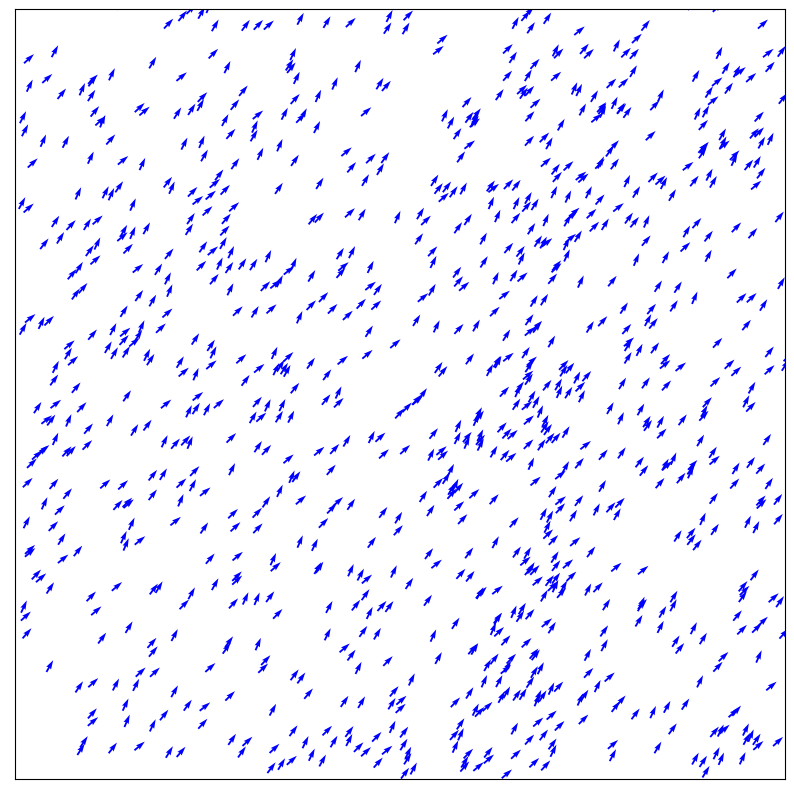

KeyboardInterrupt: 

In [16]:
# set up a figure
fig, ax = plt.subplots(figsize = (10,10))

# get the initial configuration for birds and drones
x_birds, y_birds, vx_birds, vy_birds, theta_birds = initialize_birds(N, L)
x_drones, y_drones, vx_drones, vy_drones = initialize_drones(num_drones, L)

# create initial quiver plot for birds
birds_quiver = ax.quiver(x_birds, y_birds, vx_birds, vy_birds, angles='xy', scale_units='xy', color='blue')

# create initial quiver plot for drones
drones_quiver = ax.quiver(x_drones, y_drones, vx_drones, vy_drones, angles='xy', scale_units='xy', color='red', label='Drones')


ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# do each step, updating the quiver and scatter plots
for iT in range(Nt):
    x_birds, y_birds, vx_birds, vy_birds,  x_drones, y_drones, vx_drones, vy_drones, theta_birds = step(x_birds, y_birds, vx_birds, vy_birds, theta_birds, Rsq, eta, N, dt, x_drones, y_drones, vx_drones, vy_drones)
    x_birds, y_birds = update_positions(x_birds, y_birds, vx_birds, vy_birds, dt, L)
    update_drones(x_drones, y_drones, vx_drones, vy_drones, x_birds, y_birds, theta_birds)
    update_birds(x_birds, y_birds, vx_birds, vy_birds, theta_birds, R, eta, N, dt, x_drones, y_drones)
    theta_birds = update_theta(x_birds, y_birds, theta_birds, Rsq, eta, N)
    vx_birds, vy_birds = update_velocities(vx_birds, vy_birds, theta_birds)

    # update quiver plot data
    birds_quiver = update_quiver(birds_quiver, x_birds, y_birds, vx_birds, vy_birds)
    
    # update scatter plot data for drones
    drones_quiver.set_offsets(np.column_stack([x_drones, y_drones]))
    
    # slight delay for visualization
    plt.pause(0.1)

    # Clear the previous plot
    clear_output(wait=True)

    # Display the new plot
    display(fig)

# Ensure the final plot stays visible
plt.show()


ValueError: too many values to unpack (expected 5)

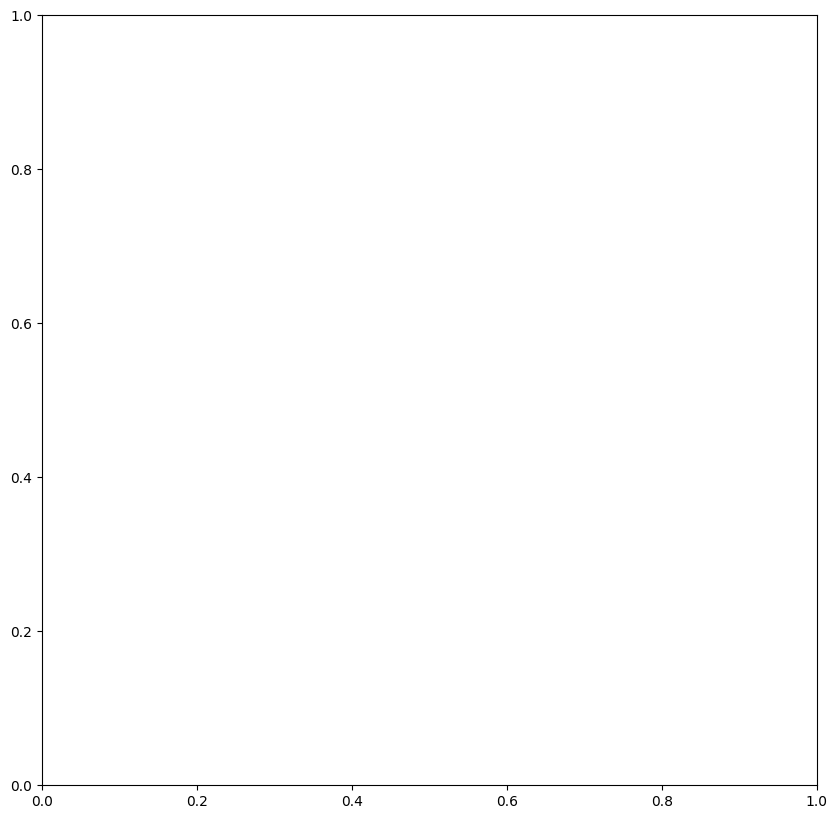

In [ ]:

# set up a figure
fig, ax = plt.subplots(figsize = (10,10))

# get the initial configuration for birds and drones
x_birds, y_birds, vx_birds, vy_birds, theta_birds = initialize_birds(N, L)
x_drones, y_drones, vx_drones, vy_drones = initialize_drones(num_drones, L)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):
    x_birds, y_birds, vx_birds, vy_birds, theta_birds = step(x_birds, y_birds, vx_birds, vy_birds, theta_birds, Rsq, eta, N, dt, x_drones, y_drones, vx_drones, vy_drones)
    x_birds, y_birds = update_positions(x_birds, y_birds, vx_birds, vy_birds, dt, L)
    update_drones(x_drones, y_drones, vx_drones, vy_drones, x_birds, y_birds, theta_birds)
    update_birds(x_birds, y_birds, vx_birds, vy_birds, theta_birds, R, eta, N, dt, x_drones, y_drones)
    theta_birds = update_theta(x_birds, y_birds, theta_birds, R, eta, N)
    vx_birds, vy_birds = update_velocities(vx_birds, vy_birds, theta_birds)


    # Plotting birds in blue
    ax.scatter(x_birds, y_birds, color='blue', s=5, label='Birds')

    # Plotting drones in red
    ax.scatter(x_drones, y_drones, color='red', s=50, label='Drones')

    ax.set(xlim=(0, L), ylim=(0, L))
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    clear_output(wait=True)
    display(fig)
